# Setup Analyis Path

In [7]:
import os
image_path = '/mnt/HypeScope/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'
pth,dataset = os.path.split(image_path)
pth,project = os.path.split(pth)
pth,user = os.path.split(pth)
analysis_path = os.path.join('/hybedata/',user,project,dataset)
if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

# Find Beads

In [ ]:
#!python {analysis_file} {image_path} {analysis_path}
!python '/home/zach/Documents/PySpots/analysis_scripts/find_beads.py' '/mnt/HypeScope/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'

use the found beads to find subpixel centers

# Find Tforms

In [ ]:
#!python {analysis_file} {bead_path} {out_path} #Find Tforms
!python '/home/zach/Documents/PySpots/analysis_scripts/find_tforms.py' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/beads.pkl' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/tforms.pkl'

# Create Codestacks

In [ ]:
#!python {analysis_file} {image_path} {codeword_conifg} {tforms_path} {out_path} -k 1 -s 2 -m 45 -i 3 --decon_iters 25
!python '/home/zach/Documents/PySpots/analysis_scripts/decon_codestacks.py' '/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/' 'seqfish_config_Inflammation' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/tforms.pkl' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks2/' -p 16 -k 1 -s 2 -m 80 -i 3 --decon_iters 25

# Classify Codestacks

In [ ]:
#!python {analysis_file} {codestack_path} {codeword_config}
!python '/home/zach/Documents/PySpots/analysis_scripts/hdata_iterative_classify_codestacks.py' '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks/' 'seqfish_config_Inflammation' -p 16 -r 49

In [ ]:
#!python {analysis_file} {codestack_path} {codeword_config}
!python '/home/zach/Documents/PySpots/analysis_scripts/mask_hdata_iterative_classify.py' '/bigstore/GeneralStorage/Zach/FISHData/codestacks/' 'seqfish_config_Inflammation' -p 12 -r 45

In [5]:
from fish_results import *
hdata = HybeData('/bigstore/GeneralStorage/Zach/FISHData/codestacks/Pos49')

In [7]:
nf = hdata.get_data(dtype='nf',posname='Pos49',zindex=10)

In [18]:
nf

array([ 298.99859619,  284.32046509,  289.07598877,  336.58181763,
        286.23727417,  289.06707764,  230.56811523,  234.22201538,
        252.67433167,  224.33306885,  317.30752563,  360.08563232,
                 nan, 3629.70849609,           nan, 2410.09326172,
        226.58895874, 1398.83496094])

In [15]:
NF = np.repeat(600,18)

In [17]:
NF

array([600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600,
       600, 600, 600, 600, 600])

In [119]:
# reset normalization factors
cstk_path = '/bigstore/GeneralStorage/Zach/FISHData/codestacks'
hybedatas = [(i, HybeData(os.path.join(cstk_path, i))) for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))]
new_nf = np.repeat(600,18)
for pos,hdata in hybedatas:
    for zindex in hdata.metadata.zindex.unique():
        hdata.add_and_save_data(new_nf, pos, zindex, 'nf')

In [138]:
import os
import numpy as np
from fish_results import *
from analysis_scripts.mask_hdata_iterative_classify import *
cstk_path = '/bigstore/GeneralStorage/Zach/FISHData/codestacks'
hybedatas = [(i, HybeData(os.path.join(cstk_path, i))) for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))]
cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
cur_nf

array([616.35502472, 631.8414662 , 589.81205313, 597.24286704,
       573.46674169, 609.87398197, 603.88894875, 558.0875936 ,
       590.11954533, 580.94400685, 558.59879605, 572.01767327,
       654.35460339, 663.63512336, 670.24964481, 690.20791133,
       599.34224761, 647.94452035])

In [140]:
pos = 'Pos4'
hdata=HybeData('/bigstore/GeneralStorage/Zach/FISHData/codestacks/Pos4')
zidxes = hdata.metadata.zindex.unique()
nfs = [hdata.load_data(pos, z, 'nf') for z in zidxes]

In [143]:
def mean_nfs(hdata, pos,zmax,zmin):
    """
    Iterate through codestacks and average norm factors.
    """
    nfs = []
    zidxes = hdata.metadata.zindex.unique()
    for z in zidxes:
        if z <= zmax:
            if z >= zmin:
                nfs.append(hdata.load_data(pos, z, 'nf'))
    #nfs = [hdata.load_data(pos, z, 'nf') for z in zidxes]
    return np.nanmean(nfs, axis=0)
mean_nfs(hdata,pos,100,0)

array([765.6998291 , 693.82652283, 742.38597616, 663.39649455,
       689.75652059, 715.19356791, 626.28041876, 621.44837379,
       589.26757685, 633.59294858, 522.30373001, 545.17988459,
       785.56442388, 801.40570831, 814.72501628, 799.92047252,
       626.9391351 , 718.67401377])

In [12]:
# fixing duplicates in metadatas 
import os
from fish_results import *
import numpy as np
from analysis_scripts.mask_hdata_iterative_classify import *
cstk_path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks'
hybedatas = [(i, HybeData(os.path.join(cstk_path, i))) for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))]
path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/temp'
for pos,hdata in hybedatas:
    metadata = hdata.metadata
    metadata = metadata[['posname','zindex','dtype','filename']]
    metadata = metadata.drop_duplicates()
    metadata.to_csv(os.path.join(hdata.base_path, 'hybedata.csv'),index=False)

In [1]:
import importlib
import numpy as np
import pandas as pd
seqfish_config = importlib.import_module('seqfish_config_Inflammation')


# Classify once with blank barcodes

In [11]:
from analysis_scripts.mask_hdata_iterative_classify import *

cword_config = 'seqfish_config_Inflammation'
cstk_path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks'
nrandom = 50
ncpu = 10
niter = 1
mask_type = 'spots'

os.environ['MKL_NUM_THREADS'] = '4'
os.environ['GOTO_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'

seqfish_config = importlib.import_module(cword_config)
all_codeword_vectors = numpy.concatenate((seqfish_config.gene_codeword_vectors,seqfish_config.blank_codeword_vectors),axis=0)
norm_all_codeword_vectors = normalize(all_codeword_vectors)
bitmap = seqfish_config.bitmap
normalized_gene_vectors = norm_all_codeword_vectors

hybedatas = [(i, HybeData(os.path.join(cstk_path, i))) for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))]


# Note preceding blocks and this can be noisy if restarted after crash etccc
# Note preceding blocks and this can be noisy if restarted after crash etccc
with multiprocessing.Pool(ncpu) as ppool:
    failed_positions = []
    for i in range(niter):
        print('N Positions left: ', len(hybedatas))
        if i == 0:
            cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            print('90th Percentile Normalization factors:', cur_nf, sep='\n')
        else:
            cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            cur_nf = np.array([10**2.6 if (i<10**2.6) or np.isnan(i) else i for i in cur_nf])
            print(cur_nf)
        classify_pfunc = partial(classify_file, nfactor=cur_nf, nvectors=normalized_gene_vectors, mask_type=mask_type)
        results = ppool.starmap(classify_pfunc, [(i[1], i[0]) for i in hybedatas])

N Positions left:  45
Pos28
Pos26
Pos48
Pos22
Pos30
Pos34
Pos44
Pos5
Pos46
Pos15
90th Percentile Normalization factors:
[645.2105705  650.07024654 548.19664103 652.54072395 510.89042921
 623.58623474 543.2892746  457.09555759 535.50341526 498.00980517
 456.64649911 512.69669053 907.46688733 981.29580799 975.6947771
 806.38766671 588.86754719 706.60727384]
Pos40
Pos14
Pos17
Pos7
Pos37
Pos1
Pos24
Pos20
Pos21
Pos35
Pos16
Pos12
Pos8
Pos42
Pos41
Pos49
Pos39
Pos29
Pos38
Pos45
Pos2
Pos10
Pos19
Pos43
Pos9
Pos33
Pos11
Pos3
Pos31
Pos4
Pos0
Pos25
Pos13


ValueError: No items for in metadata matching request.

In [ ]:
from fish_results import *
import os
import importlib
import pickle
from analysis_scripts.parse_classification_images import *
import pandas as pd
import numpy
from metadata import Metadata
from collections import defaultdict, Counter
img_path = '/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'
md = Metadata(img_path)

path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks'
hdata = HybeData(path)
seqfish_config = importlib.import_module('seqfish_config_Inflammation')
cvectors = numpy.concatenate((seqfish_config.gene_codeword_vectors,seqfish_config.blank_codeword_vectors),axis=0)
genes = seqfish_config.gids+seqfish_config.bids

pos_df = {}
counts = []
FISH_Spots = {}
DF = []
for pos in hdata.metadata.posname.unique():
    hdata = HybeData(os.path.join(path,pos))
    merged_df = {}
    XY = md.image_table[md.image_table.Position==pos].XY.iloc[0]
    print(pos)
    for zindex in hdata.metadata.zindex.unique():
        temp = md.image_table[md.image_table.Position==pos]
        Z = temp[md.image_table[md.image_table.Position==pos].Zindex==zindex].Z.iloc[0]
        cstk = hdata.load_data(pos, zindex, 'cstk')
        class_img = hdata.load_data(pos, zindex, 'cimg')
        df,bit_values = parse_classification_image(class_img,cstk,cvectors,genes,zindex)
        df['z'] = zindex
        df['Position'] = pos
        df['coordX'] = XY[1]
        df['coordY'] = XY[0]
        df['coordZ'] = Z
        merged_df[zindex] = df
        DF.append(df)
        counts = Counter(df.gene)
        for gene in counts.keys():
            if gene not in FISH_Spots.keys():
                FISH_Spots[gene] = 0
            FISH_Spots[gene] = FISH_Spots[gene] + counts[gene]
    pos_df[pos] = merged_df
    df = pd.concat(DF, ignore_index=True)
pickle.dump(df,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/df2.pkl','wb'))   
pickle.dump(FISH_Spots,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/FISH_Spots_all.pkl','wb'))

# Generate Data Frame

In [56]:
from fish_results import *
import os
import importlib
import pickle
from analysis_scripts.parse_classification_images import *
import pandas as pd
import numpy
img_path = '/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'
md = Metadata(img_path)

path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks'
hdata = HybeData(path)
seqfish_config = importlib.import_module('seqfish_config_Inflammation')
cvectors = numpy.concatenate((seqfish_config.gene_codeword_vectors,seqfish_config.blank_codeword_vectors),axis=0)
genes = seqfish_config.aids

pos_df = {}
counts = []
FISH_Spots = {}
DF = []
for pos in hdata.metadata.posname.unique():
    hdata = HybeData(os.path.join(path,pos))
    merged_df = {}
    XY = md.image_table[md.image_table.Position==pos].XY.iloc[0]
    print(pos)
    for zindex in hdata.metadata.zindex.unique():
        temp = md.image_table[md.image_table.Position==pos]
        Z = temp[md.image_table[md.image_table.Position==pos].Zindex==zindex].Z.iloc[0]
        cstk = hdata.load_data(pos, zindex, 'cstk')
        class_img = hdata.load_data(pos, zindex, 'cimg')
        df,bit_values = parse_classification_image(class_img,cstk,cvectors,genes,zindex)
        df['z'] = zindex
        df['Position'] = pos
        df['coordXY'] = XY
        df['coordZ'] = Z
        merged_df[zindex] = df
        DF.append(df)
        counts = Counter(df.gene)
        for gene in counts.keys():
            if gene not in FISH_Spots.keys():
                FISH_Spots[gene] = 0
            FISH_Spots[gene] = FISH_Spots[gene] + counts[gene]
    pos_df[pos] = merged_df
    df = pd.concat(DF, ignore_index=True)
pickle.dump(df,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/df_all.pkl','wb'))   
pickle.dump(FISH_Spots,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/FISH_Spots_all.pkl','wb'))

Pos26
Pos17
Pos28
Pos24
Pos22
Pos1
Pos48
Pos21
Pos30
Pos14
Pos34
Pos37
Pos5
Pos20


KeyboardInterrupt: 

In [12]:
from fish_results import *
import os
import importlib
import pickle
from analysis_scripts.parse_classification_images import *
import pandas as pd
import numpy
from metadata import Metadata
from collections import defaultdict, Counter
img_path = '/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'
md = Metadata(img_path)

path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks'
hdata = HybeData(path)
seqfish_config = importlib.import_module('seqfish_config_Inflammation')
cvectors = numpy.concatenate((seqfish_config.gene_codeword_vectors,seqfish_config.blank_codeword_vectors),axis=0)
genes = seqfish_config.gids+seqfish_config.bids

pos_df = {}
counts = []
FISH_Spots = {}
DF = []
for pos in hdata.metadata.posname.unique():
    hdata = HybeData(os.path.join(path,pos))
    merged_df = {}
    XY = md.image_table[md.image_table.Position==pos].XY.iloc[0]
    print(pos)
    for zindex in hdata.metadata.zindex.unique():
        temp = md.image_table[md.image_table.Position==pos]
        Z = temp[md.image_table[md.image_table.Position==pos].Zindex==zindex].Z.iloc[0]
        cstk = hdata.load_data(pos, zindex, 'cstk')
        class_img = hdata.load_data(pos, zindex, 'cimg')
        df,bit_values = parse_classification_image(class_img,cstk,cvectors,genes,zindex)
        df['z'] = zindex
        df['Position'] = pos
        df['coordX'] = XY[0]
        df['coordY'] = XY[1]
        df['coordZ'] = Z
        merged_df[zindex] = df
        DF.append(df)
        counts = Counter(df.gene)
        for gene in counts.keys():
            if gene not in FISH_Spots.keys():
                FISH_Spots[gene] = 0
            FISH_Spots[gene] = FISH_Spots[gene] + counts[gene]
    pos_df[pos] = merged_df
    df = pd.concat(DF, ignore_index=True)
pickle.dump(df,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/df2.pkl','wb'))   
pickle.dump(FISH_Spots,open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/FISH_Spots_all.pkl','wb'))

Pos26
Pos17
Pos28
Pos24
Pos22
Pos1
Pos48
Pos21
Pos30
Pos14
Pos34
Pos37
Pos5
Pos20
Pos44
Pos35
Pos15
Pos40
Pos46
Pos7
Pos16
Pos19
Pos12
Pos43
Pos8
Pos9
Pos42
Pos33
Pos41
Pos11
Pos49
Pos3
Pos39
Pos4
Pos29
Pos31
Pos38
Pos23
Pos45
Pos0
Pos2
Pos6
Pos10
Pos25
Pos13


In [50]:
FISH_Spots

{'Notch2': 9891,
 'Ahnak2': 8312,
 'Apc': 572,
 'Tgfbr2': 191,
 'Stat3': 1437,
 'Il6ra': 282,
 'Lamb2': 369,
 'Lrp5': 430,
 'Ppard': 963,
 'P2ry2': 1777,
 'Bcl2l1': 2325,
 'Ccnd1': 180,
 'Timp2': 83,
 'Esr1': 6052,
 'Fzd5': 91,
 'Naip6': 47,
 'Akt2': 478,
 'Sbno2': 2107,
 'Pcdh7': 1116,
 'Bcl6': 805,
 'Irak2': 465,
 'Gja1': 4123,
 'Tnfrsf21': 1801,
 'Nlrx1': 16933,
 'Pak1': 356,
 'Tbc1d23': 55311,
 'Ldlr': 2685,
 'Itga6': 1312,
 'Notch1': 1309,
 'Abhd2': 14261,
 'Myh9': 4393,
 'Elk3': 321,
 'Lamc1': 87,
 'Stat5a': 56,
 'Rab31': 375,
 'Ikbkb': 599,
 'Rps6ka4': 787,
 'Tgm2': 2963,
 'Fzd7': 273,
 'Drosha': 206,
 'Jaml': 52,
 'Mcph1': 174,
 'Dvl1': 1445,
 'Sufu': 136,
 'Clock': 102,
 'Serpine1': 490,
 'Ptgs1': 184,
 'Irak4': 200,
 'Maml1': 258,
 'Tnfrsf26': 214,
 'Nfkb1': 529,
 'Numb': 656,
 'Prkch': 673,
 'Prkci': 724,
 'Ash1l': 139,
 'Tgfbr1': 267,
 'Bcl2': 148,
 'Clasp2': 29,
 'Tnip1': 972,
 'P2ry1': 18,
 'Kdm6b': 1516,
 'Acaca': 55,
 'Nr1d2': 132,
 'Ndst1': 158,
 'Per1': 215,
 'P2rx7':

In [48]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(df.ave,bins=500)
plt.xlim([0, 1000])

(0, 1000)

(0, 1000)

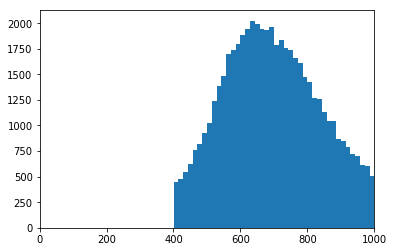

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
df_trimmed = df[(df.ave>400)]# & (df.npixels>1)]
plt.hist(df_trimmed.ave,bins=500)
plt.xlim([0, 1000])

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


<IPython.core.display.Javascript object>


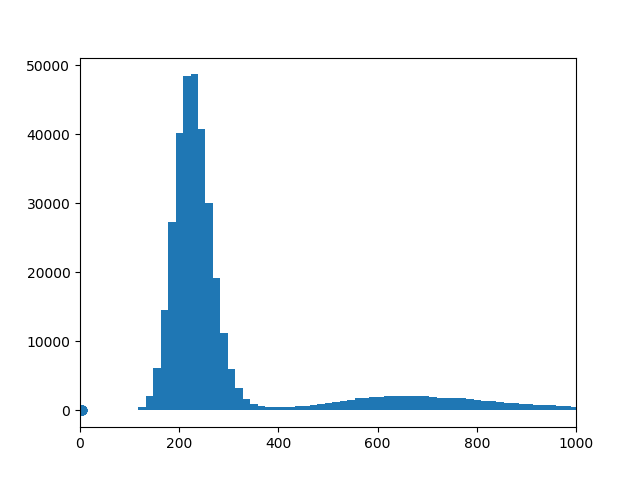

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2


SpearmanrResult(correlation=0.5154942247630003, pvalue=1.6269182892743336e-12)

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
#RNA_Expression = pd.read_csv('/home/zach/Downloads/Cornea Wound Gene List - Inflammation Final.csv')
ReadsPerGene = pd.read_excel('/bigstore/GeneralStorage/Zach/Cornea_RNAseq/Aligned/ReadsPerGene.xlsx')
GeneList = pd.read_excel('/bigstore/GeneralStorage/Zach/MERFISH/Inflammatory/InflammationGeneList.xlsx')
vals = []
for gn,cc in FISH_Spots.items():
    gid = GeneList.Gene_ID[GeneList.Gene==gn].tolist()[0]
    counts = ReadsPerGene[ReadsPerGene.GeneIDs==gid].Unstranded.values
    fpkm = counts/GeneList.Length[GeneList.Gene==gn].tolist()[0]
    if len(fpkm)>0:
        if cc<2:
            continue
        vals.append((fpkm[0],cc))
fpkms,ccs = zip(*vals)
ccs = list(np.array(ccs)/(36))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms),np.log2(np.divide(ccs,3.6)))
spearmanr(np.log2(fpkms),np.log2(ccs))

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
RNA_Expression = pd.read_csv('/home/zach/Downloads/Cornea Wound Gene List - Inflammation Final.csv')
vals = []
for gn,cc in FISH_Spots.items():
    fpkm = RNA_Expression[RNA_Expression.Gene==gn].FPKM.values
    if len(fpkm)>0:
        if cc<2:
            continue
        vals.append((fpkm[0],cc))
fpkms,ccs = zip(*vals)
ccs = list(np.array(ccs)/(36))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms),np.log2(np.divide(ccs,3.6)))
spearmanr(np.log2(fpkms),np.log2(ccs))

In [24]:
from collections import defaultdict, Counter
trimmed_df = df[df.ave>400]
#trimmed_df = trimmed_df[trimmed_df.npixels>1]
trimmedGeneSpots = Counter(trimmed_df.gene)

<IPython.core.display.Javascript object>


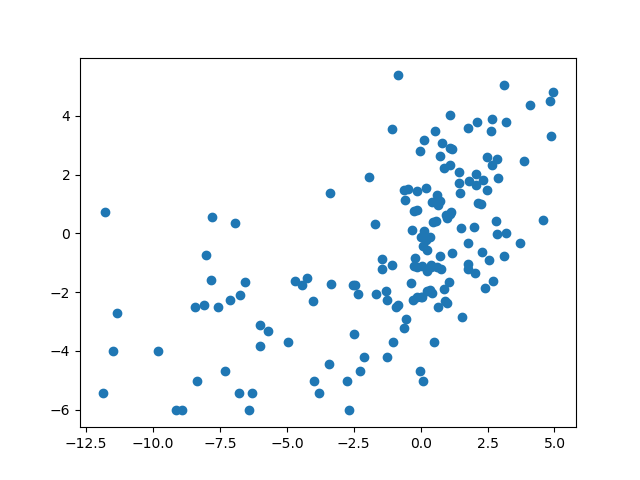

SpearmanrResult(correlation=0.63699452905311, pvalue=8.09199198115459e-20)

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#RNA_Expression = pd.read_csv('/home/zach/Downloads/Cornea Wound Gene List - Inflammation Final.csv')
ReadsPerGene = pd.read_excel('/bigstore/GeneralStorage/Zach/Cornea_RNAseq/Aligned/ReadsPerGene.xlsx')
GeneList = pd.read_excel('/bigstore/GeneralStorage/Zach/MERFISH/Inflammatory/InflammationGeneList.xlsx')
vals = []
for gn,cc in trimmedGeneSpots.items():
    gid = GeneList.Gene_ID[GeneList.Gene==gn].tolist()[0]
    counts = ReadsPerGene[ReadsPerGene.GeneIDs==gid].Unstranded.values
    fpkm = counts/GeneList.Length[GeneList.Gene==gn].tolist()[0]
    if len(fpkm)>0:
        if cc<2:
            continue
        vals.append((fpkm[0],cc))
fpkms,ccs = zip(*vals)
ccs = list(np.array(ccs)/(36))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms),np.log2(np.divide(ccs,3.6)))
spearmanr(np.log2(fpkms),np.log2(ccs))

# Load Results

In [6]:
import pickle
beads = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/beads.pkl','rb'))
tforms = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/tforms.pkl','rb'))
FISH_Spots = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/FISH_Spots.pkl','rb'))
DF = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/DF.pkl','rb'))

KeyboardInterrupt: 

# Test Registration

In [91]:
def tform_image(cstk, channel, tvect, niter=25):
    """
    Warp images to correct chromatic abberation and translational stage drift.

    Parameters
    ----------
    cstk : ndarray
       Image(s) to be warped
    channel : str
       Name of channel (used to determine which chromatic warping to apply)
    tvect : tuple
       Tuple of floats to correct for stage drift

    Returns
    -------
    cstk : ndarray float32
       Warped image of same shape as input cstk

    Notes - Chromatic abberation maps are imported from seqfish_config and as accessed as globals
    """
    if channel == 'DeepBlue':
        xs, ys = yshift_db+tvect[1], xshift_db+tvect[0]
       #return cstk.astype('float32')
    if channel == 'Orange':
        xs, ys = numpy.linspace(0, 2047, 2048)+tvect[1], numpy.linspace(0, 2047, 2048)+tvect[0]
        cstk = dogonvole(cstk, orange_psf, niter=niter)
    elif channel=='Green':
        xs, ys = yshift_g+tvect[1], xshift_g+tvect[0]
        cstk = dogonvole(cstk, green_psf, niter=niter)
    elif channel=='FarRed':
        xs, ys = yshift_fr+tvect[1], xshift_fr+tvect[0]
        cstk = dogonvole(cstk, farred_psf, niter=niter)
    cstk = interp_warp(cstk, xs, ys)
    return cstk.astype('float32')


def load_and_tform_bead_images(posname, md_path, tforms_xy, tforms_z
                              ,zstart=6, k=1,
                              reg_ref = 'hybe1',
                              ndecon_iter=2):
    """
    Wrapper for multiple Z codestack where each is max_projection of few frames above and below.
    """
    hnames = ['hybe'+str(i) for i in range(1, 10)]
    md = Metadata(md_path)
    xy = tforms_xy
    z = tforms_z
    z = {k: int(np.round(np.mean(v))) for k, v in z.items()}
    z[reg_ref] = 0
    xy[reg_ref] = (0,0)
    cstk = []
    for hybe in hnames:
        t = xy[hybe]
        zindexes = list(range(zstart-z[hybe]-k, zstart-z[hybe]+k+1))
        #print(zindexes)
        zstk = md.stkread(Channel='DeepBlue', hybe=hybe,
                          Position=posname, Zindex=zindexes)
        zstk = zstk.max(axis=2)
        zstk = tform_image(zstk, 'DeepBlue', t, niter=ndecon_iter)
        cstk.append(zstk)
        del zstk
    cstk = np.stack(cstk, axis=2)
    return cstk#, nf

In [92]:
from metadata import *
from hybescope_config.microscope_config import *
from analysis_scripts.decon_codestacks import *
pos = 'Pos0'
md_path = '/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/'
tforms = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/tforms.pkl','rb'))
xy={}
z = {}
for h in tforms['good'][pos].keys():
    x = tforms['good'][pos][h][0][0]
    y = tforms['good'][pos][h][0][1]
    z[h] = tforms['good'][pos][h][0][2]
    xy[h] = [x,y]
reg_test = load_and_tform_bead_images(pos,md_path,xy,z,zstart=5)
ref_reg = reg_test[:,:,1]
test_reg = reg_test[:,:,2]
xy_raw={}
z_raw = {}
for h in tforms['good'][pos].keys():
    x = 0
    y = 0
    z_raw[h] = 0
    xy_raw[h] = [x,y]
raw_test = load_and_tform_bead_images(pos,md_path,xy_raw,z_raw,zstart=5)
ref_raw = raw_test[:,:,1]
test_raw = raw_test[:,:,2]

opening img_Pos0_000000006_000000000_DeepBlue_000_006.tif

<IPython.core.display.Javascript object>


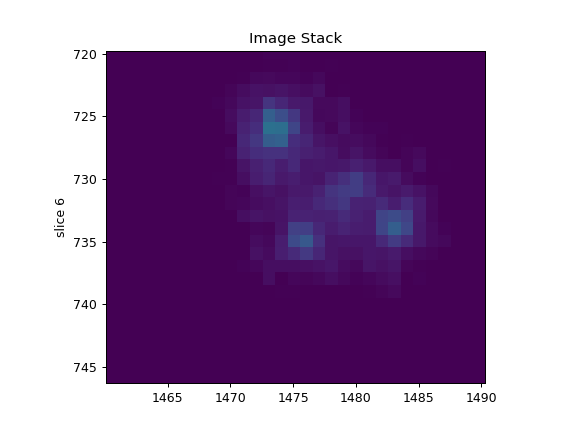

In [96]:
%matplotlib notebook
import matplotlib.pyplot as plt
from __future__ import print_function
class stkshow(object):
    def __init__(self, X, min_thresh=5,max_thresh=95):
        self.fig, self.ax = plt.subplots(1,1)
        self.ax.set_title('Image Stack') # Title
        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2
        self.vmin = np.percentile(self.X,min_thresh)
        self.vmax = np.percentile(self.X,max_thresh)
        self.im = self.ax.imshow(self.X[:, :, self.ind], vmin=self.vmin, vmax=self.vmax)
        self.fig.canvas.mpl_connect('scroll_event', self.onscroll)
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()
        plt.show()
#stkshow(reg_test)

<IPython.core.display.Javascript object>


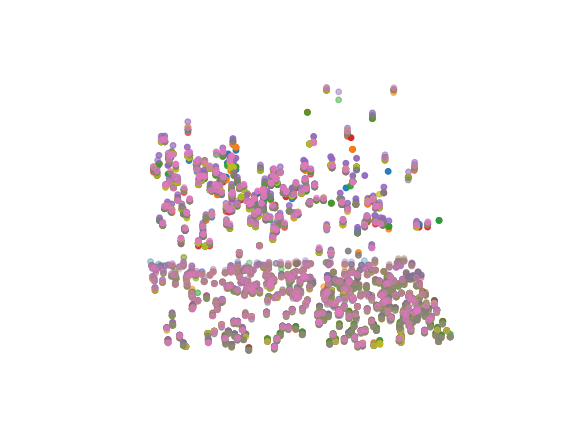

In [64]:
%matplotlib notebook
beads = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/beads.pkl','rb'))
tforms = pickle.load(open('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/results/tforms.pkl','rb'))
from mpl_toolkits.mplot3d import axes3d, Axes3D
Pos = 'Pos15'
fig = plt.figure()
ax = Axes3D(fig)
for h in beads[Pos].keys():
    beads[Pos][h] = beads[Pos][h]+tforms['good'][Pos][h][0]
    X, Y, Z = beads[Pos][h][:,0], beads[Pos][h][:,1], beads[Pos][h][:,2]
    cset = ax.scatter(X, Y, Z)
    ax.clabel(cset, fontsize=9, inline=1)
# A = beads[Pos]['hybe1']
# X, Y, Z = A[:,0], A[:,1], A[:,2]
# cset = ax.scatter(X, Y, Z)
# ax.clabel(cset, fontsize=9, inline=1)
# B = beads[Pos]['hybe2'] + [ 3.07579842, -0.28712367, -1]
# X, Y, Z = B[:,0], B[:,1], B[:,2]
# cset = ax.scatter(X, Y, Z)
# ax.clabel(cset, fontsize=9, inline=1)

ax.grid(False)
plt.axis('off')
plt.show()

# Testing segmentation and masking before clasificaiton

In [21]:
from fish_results import*
import numpy as np
import os
import multiprocessing
def make_nf(hdata,pos,nf_init_qtile=95):
    print(pos)
    for z in hdata.metadata.zindex.unique():
        nf = [400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400]
        hdata.add_and_save_data(nf, pos, z, 'nf')

cstk_path = '/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks/'
hybedatas = [(i, HybeData(os.path.join(cstk_path, i))) for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))]
ncpu = 12
with multiprocessing.Pool(ncpu) as ppool:
    ppool.starmap(make_nf, [(i[1], i[0]) for i in hybedatas])

No columns to parse from file
Pos24
Pos22
Pos32
Pos50
Pos26
Pos28
Pos21
Pos1
Pos17
Pos30
Pos14
Pos48
Pos34
Pos37
Pos20
Pos5
Pos44
Pos35
Pos15
Pos40
Pos46
Pos7
Pos16
Pos19
Pos12
Pos43
Pos8
Pos9
Pos42
Pos33
Pos41
Pos11
Pos49
Pos3
Pos39
Pos4
Pos29
Pos31
Pos38
Pos23
Pos45
Pos0
Pos2
Pos6
Pos10
Pos25
Pos47
Pos13


In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import multiprocessing as mp
import pickle
from itertools import repeat
from collections import defaultdict
from functools import partial
from skimage import io, restoration
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from metadata import *
from skimage.filters import gaussian, threshold_adaptive, threshold_local
from scipy import ndimage
from skimage.morphology import selem, watershed, remove_small_objects
from skimage.measure import regionprops, label
from skimage import feature
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
import imreg_dft as ird
import bisect
from skimage.color import label2rgb

In [10]:
from analysis_scripts.mask_hdata_iterative_classify import*
from fish_results import*
import numpy as np
hdata = HybeData('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks/Pos0')
seqfish_config = importlib.import_module('seqfish_config_Inflammation')
pos = 'Pos0'
nfactor = np.array(np.nanmean([mean_nfs(hdata, pos)], axis=0))
nvectors = seqfish_config.norm_gene_codeword_vectors
for i in range(10):
    classify_file(hdata, pos, nfactor, nvectors,mask_type = 'spots')
    print('iteration number', i)
    print('normalization factors')
    print(np.array(np.nanmean([mean_nfs(hdata, pos)], axis=0)))

Pos0
iteration number 0
normalization factors
[686.62000175 706.3153423  769.78476969 727.52944391 668.86240351
 765.46077104 595.11419387 628.43803333 633.60315635 540.31029765
 489.86354342 548.22883388 809.70773461 826.3646809  779.54108683
 732.53791656 628.82217889 664.41105893]
Pos0
iteration number 1
normalization factors
[686.62000175 706.3153423  769.78476969 727.52944391 668.86240351
 765.46077104 595.11419387 628.43803333 633.60315635 540.31029765
 489.86354342 548.22883388 809.70773461 826.3646809  779.54108683
 732.53791656 628.82217889 664.41105893]
Pos0
iteration number 2
normalization factors
[686.62000175 706.3153423  769.78476969 727.52944391 668.86240351
 765.46077104 595.11419387 628.43803333 633.60315635 540.31029765
 489.86354342 548.22883388 809.70773461 826.3646809  779.54108683
 732.53791656 628.82217889 664.41105893]
Pos0
iteration number 3
normalization factors
[686.62000175 706.3153423  769.78476969 727.52944391 668.86240351
 765.46077104 595.11419387 628.43

MemoryError: 

In [65]:
from metadata import*
path = '/mnt/HypeScope/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17'
md = Metadata(path)
nucstk = md.stkread(Channel='DeepBlue',acq='nucstain_1',Position='Pos0')
orangestk = md.stkread(Channel='Orange',hybe='hybe1',Position='Pos0')
redstk = md.stkread(Channel='FarRed',hybe='hybe1',Position='Pos0')

opening img_Pos0_000000081_000000000_FarRed_000_081.tifif

<IPython.core.display.Javascript object>


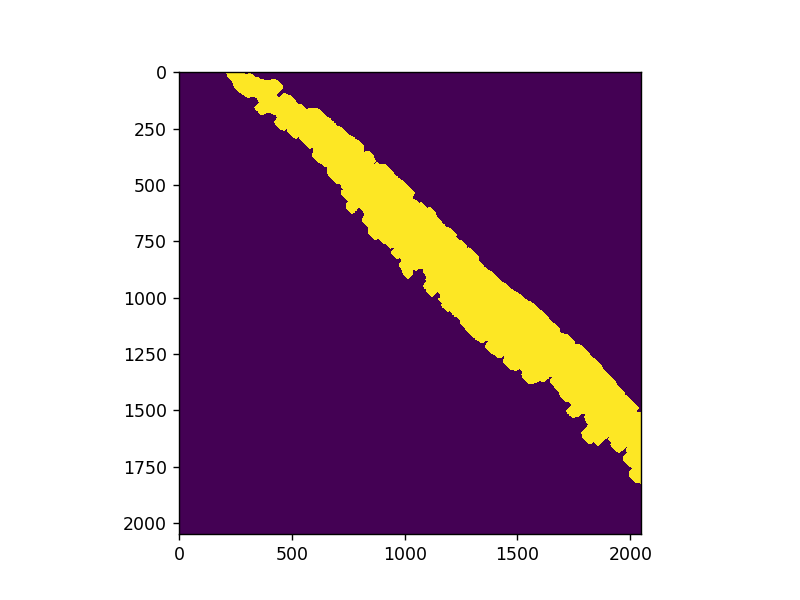

In [313]:
from fish_results import HybeData
import copy
from scipy import ndimage
from skimage.morphology import remove_small_objects
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

hdata = HybeData('/hybedata/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/codestacks/Pos0')
cstk = hdata.load_data(pos, z, 'cstk')
img = np.max(cstk,axis=2)
blurr = ndimage.gaussian_filter(img,7)
thresh = np.percentile(blurr,90)
binary = blurr>thresh
fill = ndimage.binary_dilation(binary,iterations=2)
remove = remove_small_objects(fill, min_size=10000)
fill = ndimage.binary_dilation(remove,iterations=20)
mask = ndimage.binary_fill_holes(fill)
%matplotlib notebook
plt.imshow(mask)

In [25]:
from analysis_scripts.mask_hdata_iterative_classify import *
def generate_mask(hdata,mask_type,cstk,pos,z,new_mask,iteration):
    if new_mask == False:
        iteration= 1
    if iteration ==0:
        if mask_type == False:
            mask = cstk[:,:,0]
            mask = mask==0
        elif mask_type == 'nuclear':
            print('Not Implemented Yet')
            mask = cstk[:,:,0]
            mask = mask==0
        elif mask_type == 'spots':
            stk = copy.copy(cstk)
            img = np.max(stk,axis=2)
            blurr = ndimage.gaussian_filter(img,7)
            thresh = np.percentile(blurr,90)
            binary = blurr>thresh
            fill = ndimage.binary_dilation(binary,iterations=2)
            remove = remove_small_objects(fill, min_size=10000)
            fill = ndimage.binary_dilation(remove,iterations=20)
            mask = ndimage.binary_fill_holes(fill)
            hdata.add_and_save_data(mask, pos, z, 'mask')
    else:
        if mask_type == False:
            mask = cstk[:,:,0]
            mask = mask==0
        elif mask_type == 'nuclear':
            print('Not Implemented Yet')
            mask = cstk[:,:,0]
            mask = mask==0
        elif mask_type == 'spots':
            if os.path.exists(os.path.join(hdata.base_path,hdata.generate_fname(pos,z,'mask', sep="_z_"))):
                mask = hdata.load_data(pos,z,'mask')
                mask = mask==1
            else:
                stk = copy.copy(cstk)
                img = np.max(stk,axis=2)
                blurr = ndimage.gaussian_filter(img,7)
                thresh = np.percentile(blurr,90)
                binary = blurr>thresh
                fill = ndimage.binary_dilation(binary,iterations=2)
                remove = remove_small_objects(fill, min_size=10000)
                fill = ndimage.binary_dilation(remove,iterations=20)
                mask = ndimage.binary_fill_holes(fill)
                #hdata.add_and_save_data(mask, pos, z, 'mask')
    return mask

<IPython.core.display.Javascript object>


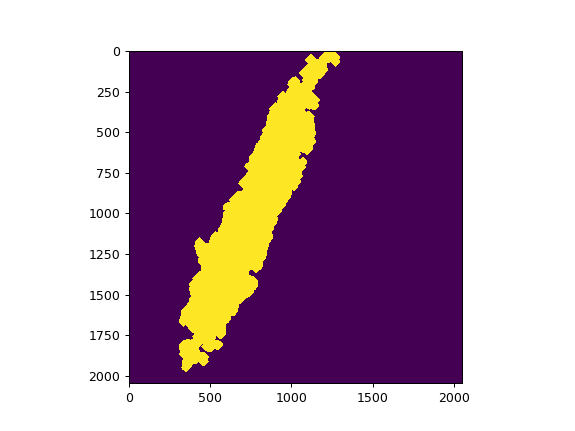

In [30]:
import matplotlib.pyplot as plt
% matplotlib notebook
pos = 'Pos42'
z = 25
hdata = HybeData('/bigstore/GeneralStorage/Zach/FISHData/codestacks/Pos42')
cstk = hdata.load_data(pos, z, 'cstk')
mask_type = 'spots'
new_mask = True
iteration = 1
mask = generate_mask(hdata,mask_type,cstk,pos,z,new_mask,iteration)
plt.imshow(mask)

In [115]:
from metadata import Metadata
pos = 'Pos42'
z = 25
md = Metadata('/bigstore/Images2018/Zach/FISH_Troubleshooting/Transverse_Wound_First_2018Sep17/nucstain_1/')

In [116]:
img = md.stkread(Position=pos,Zindex=z,Channel='DeepBlue')

opening img_Pos42_000000025_000000000_DeepBlue_000_025.tif

In [122]:
hdata = HybeData('/bigstore/GeneralStorage/Zach/FISHData/codestacks/Pos4')

In [137]:
hdata = HybeData('/bigstore/GeneralStorage/Zach/FISHData/codestacks/Pos38')
for z in np.unique(hdata.metadata.zindex):
    print(z)
    print(hdata.load_data(dtype='nf',zindex=z,posname='Pos38'))

10
[ 759.87445068 1107.12109375  873.95959473  532.29260254  759.85394287
  929.63842773  734.64935303  521.98278809  630.16070557  696.24865723
  448.23678589  642.05059814  775.1661377   583.22979736  754.65783691
  815.56787109  698.10699463  812.60949707]
13
[558.27490234 689.98480225 674.28393555 725.63250732 687.24060059
 739.95953369 553.89868164 797.41571045 579.7946167  562.17767334
 551.78765869 715.3885498  918.63226318 757.09912109 939.93505859
 693.23712158 800.19268799 735.29431152]
16
[719.48760986 855.84747314 717.74829102 810.99676514 567.8338623
 545.83953857 688.80755615 814.40283203 662.94055176 773.50500488
 489.70367432 672.02893066 858.62109375 839.14703369 801.21221924
 830.77856445 613.84020996 718.63354492]
19
[772.36950684 726.5612793  784.06463623 835.79608154 780.25933838
 781.27600098 691.29882812 602.83282471 613.51037598 644.41186523
 515.85186768 586.21459961 924.5892334  895.65014648 909.36248779
 705.96990967 684.3013916  757.0222168 ]
22
[712.6032104

In [134]:
np.unique(hdata.metadata.zindex)

array([10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58,
       61, 64, 67, 70, 73, 76, 79])

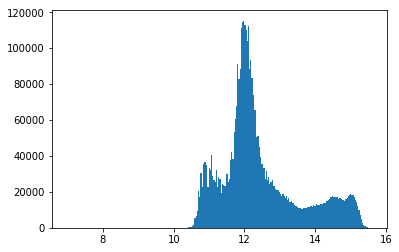

In [53]:
fig,ax = plt.subplots()
ax.hist(np.log2(img.ravel()),bins=256)
plt.show()

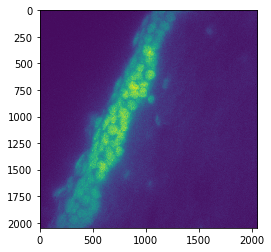

In [41]:
plt.imshow(img[:,:,0])

In [101]:
md.Zindexes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

opening img_Pos42_000000001_000000000_DeepBlue_000_001.tif

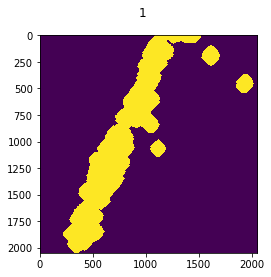

opening img_Pos42_000000002_000000000_DeepBlue_000_002.tif

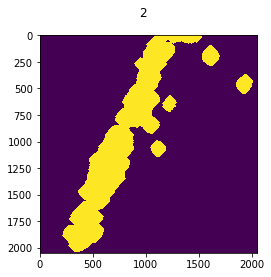

opening img_Pos42_000000003_000000000_DeepBlue_000_003.tif

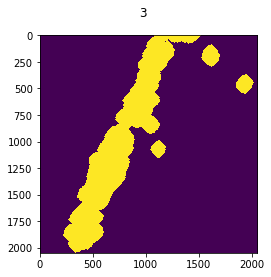

opening img_Pos42_000000004_000000000_DeepBlue_000_004.tif

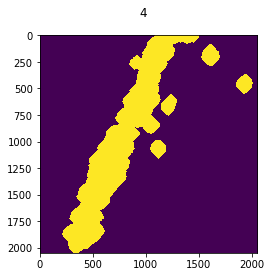

opening img_Pos42_000000005_000000000_DeepBlue_000_005.tif

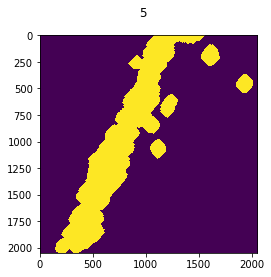

opening img_Pos42_000000006_000000000_DeepBlue_000_006.tif

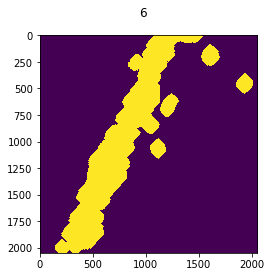

opening img_Pos42_000000007_000000000_DeepBlue_000_007.tif

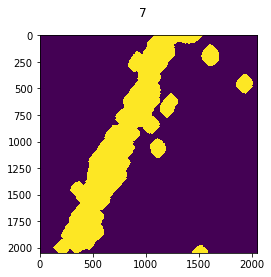

opening img_Pos42_000000008_000000000_DeepBlue_000_008.tif

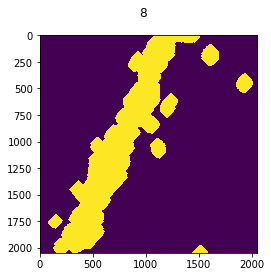

opening img_Pos42_000000009_000000000_DeepBlue_000_009.tif

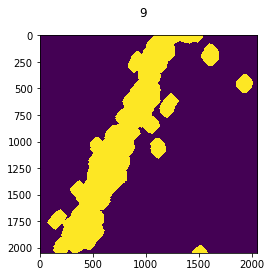

opening img_Pos42_000000010_000000000_DeepBlue_000_010.tif

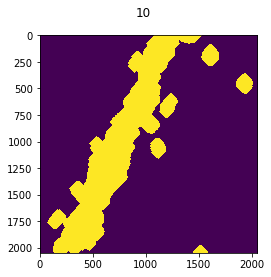

opening img_Pos42_000000011_000000000_DeepBlue_000_011.tif

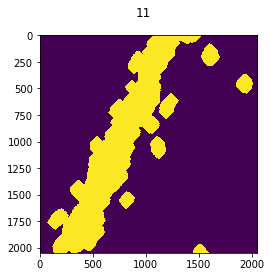

opening img_Pos42_000000012_000000000_DeepBlue_000_012.tif

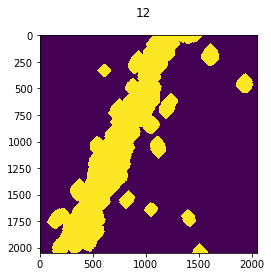

opening img_Pos42_000000013_000000000_DeepBlue_000_013.tif

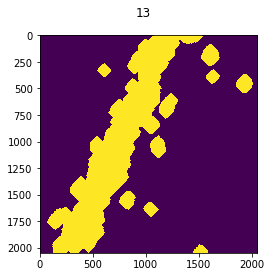

opening img_Pos42_000000014_000000000_DeepBlue_000_014.tif

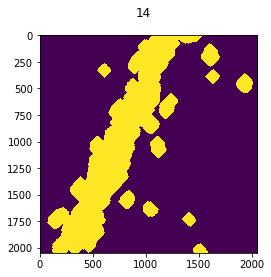

opening img_Pos42_000000015_000000000_DeepBlue_000_015.tif

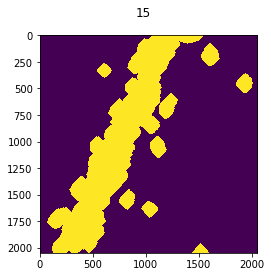

opening img_Pos42_000000016_000000000_DeepBlue_000_016.tif

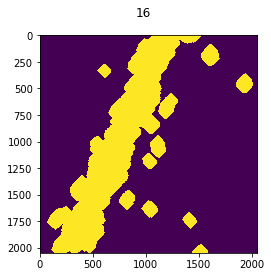

opening img_Pos42_000000017_000000000_DeepBlue_000_017.tif

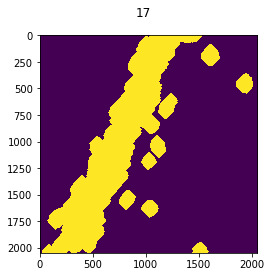

opening img_Pos42_000000018_000000000_DeepBlue_000_018.tif

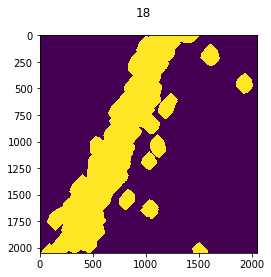

opening img_Pos42_000000019_000000000_DeepBlue_000_019.tif

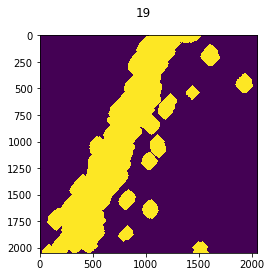

opening img_Pos42_000000020_000000000_DeepBlue_000_020.tif

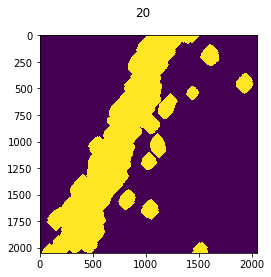

opening img_Pos42_000000021_000000000_DeepBlue_000_021.tif

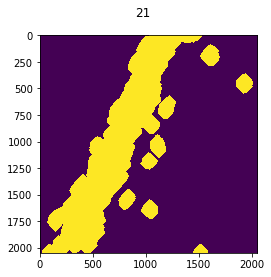

opening img_Pos42_000000022_000000000_DeepBlue_000_022.tif

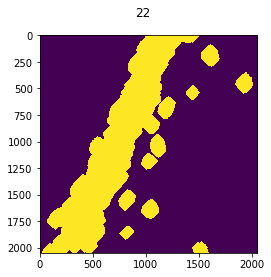

opening img_Pos42_000000023_000000000_DeepBlue_000_023.tif

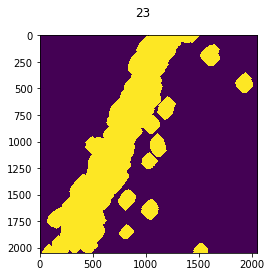

opening img_Pos42_000000024_000000000_DeepBlue_000_024.tif

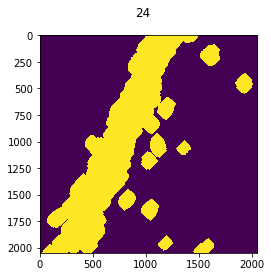

opening img_Pos42_000000025_000000000_DeepBlue_000_025.tif

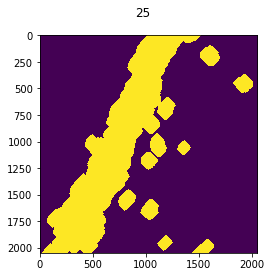

opening img_Pos42_000000026_000000000_DeepBlue_000_026.tif

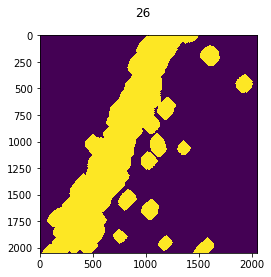

opening img_Pos42_000000027_000000000_DeepBlue_000_027.tif

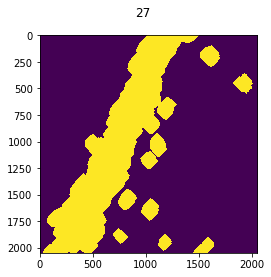

opening img_Pos42_000000028_000000000_DeepBlue_000_028.tif

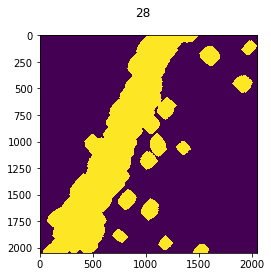

opening img_Pos42_000000029_000000000_DeepBlue_000_029.tif

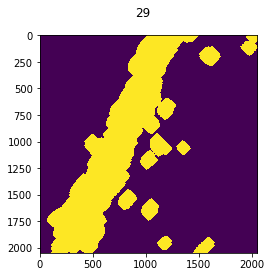

opening img_Pos42_000000030_000000000_DeepBlue_000_030.tif

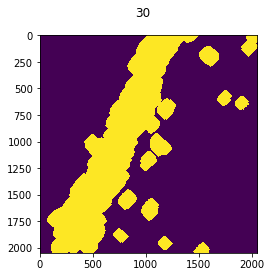

opening img_Pos42_000000031_000000000_DeepBlue_000_031.tif

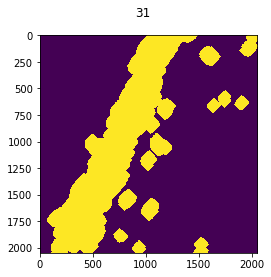

opening img_Pos42_000000032_000000000_DeepBlue_000_032.tif

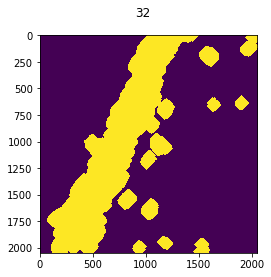

opening img_Pos42_000000033_000000000_DeepBlue_000_033.tif

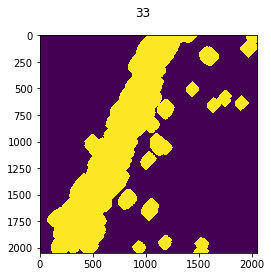

opening img_Pos42_000000034_000000000_DeepBlue_000_034.tif

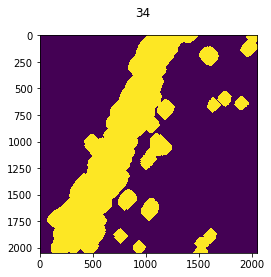

opening img_Pos42_000000035_000000000_DeepBlue_000_035.tif

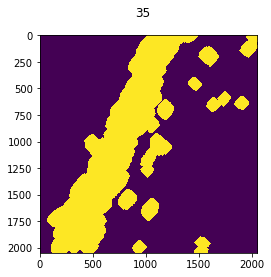

opening img_Pos42_000000036_000000000_DeepBlue_000_036.tif

KeyboardInterrupt: 

In [102]:
% matplotlib inline
import scipy.ndimage
from skimage.filters import threshold_local
for z in md.Zindexes:
    img = md.stkread(Position=pos,Zindex=z,Channel='DeepBlue',acq='nucstain_1')
    thresh = threshold_local(img[:,:,0],325,offset=0)
    binary = img[:,:,0]>thresh
    erode = ndimage.binary_erosion(binary)
    remove = remove_small_objects(erode, min_size=500)
    fill = ndimage.binary_fill_holes(remove)
    dialate = ndimage.binary_dilation(fill,iterations=50)
    mask = ndimage.binary_fill_holes(dialate)
    plt.suptitle(z)
    plt.imshow(mask)
    plt.show()

opening img_Pos0_000000025_000000000_DeepBlue_000_025.tif

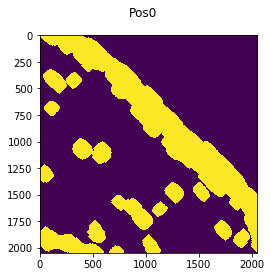

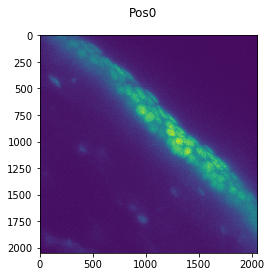

opening img_Pos1_000000025_000000000_DeepBlue_000_025.tif

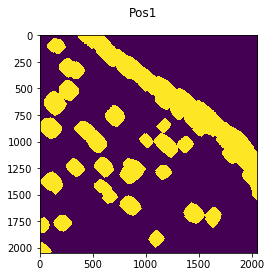

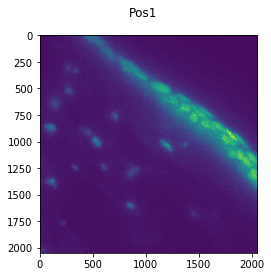

opening img_Pos2_000000025_000000000_DeepBlue_000_025.tif

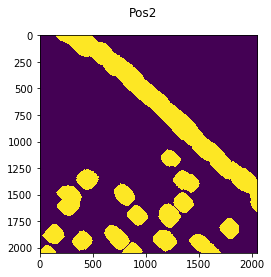

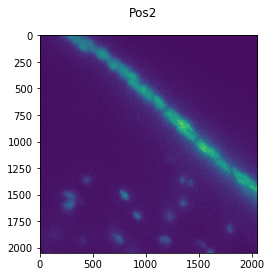

opening img_Pos3_000000025_000000000_DeepBlue_000_025.tif

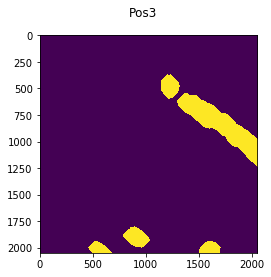

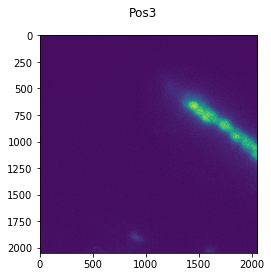

opening img_Pos4_000000025_000000000_DeepBlue_000_025.tif

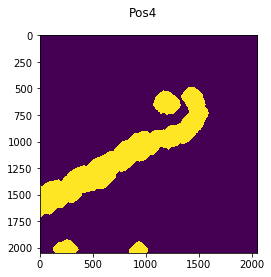

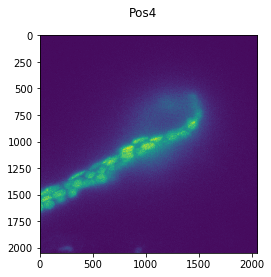

opening img_Pos5_000000025_000000000_DeepBlue_000_025.tif

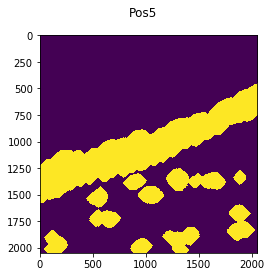

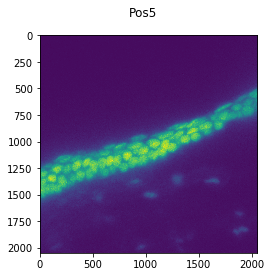

opening img_Pos6_000000025_000000000_DeepBlue_000_025.tif

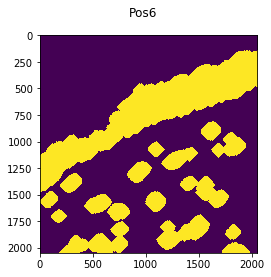

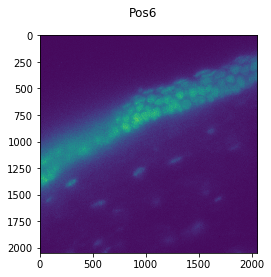

opening img_Pos7_000000025_000000000_DeepBlue_000_025.tif

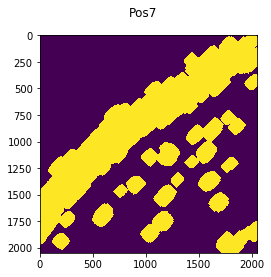

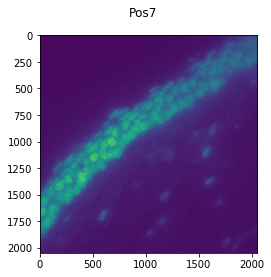

opening img_Pos8_000000025_000000000_DeepBlue_000_025.tif

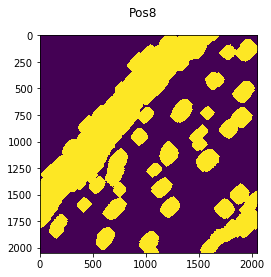

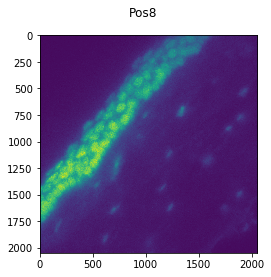

opening img_Pos9_000000025_000000000_DeepBlue_000_025.tif

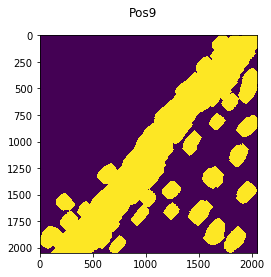

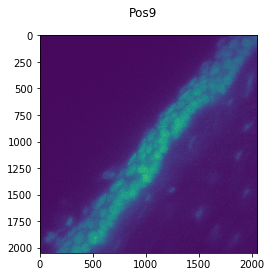

opening img_Pos10_000000025_000000000_DeepBlue_000_025.tif

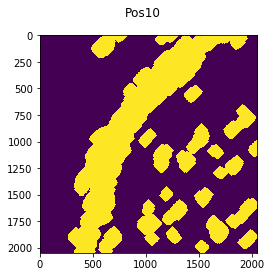

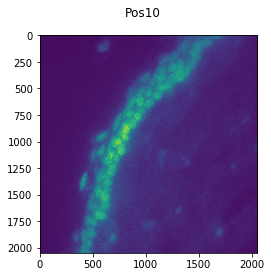

opening img_Pos11_000000025_000000000_DeepBlue_000_025.tif

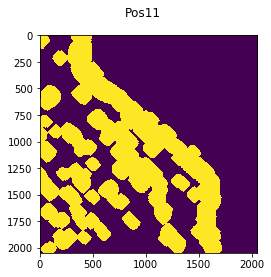

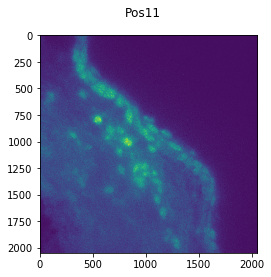

opening img_Pos12_000000025_000000000_DeepBlue_000_025.tif

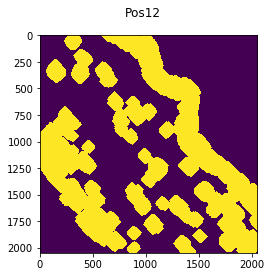

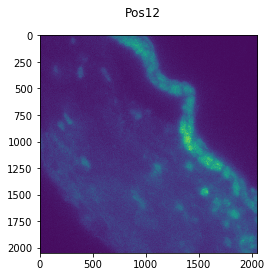

opening img_Pos13_000000025_000000000_DeepBlue_000_025.tif

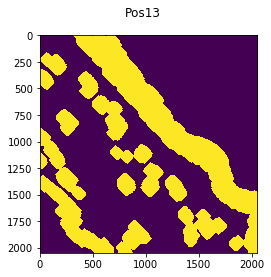

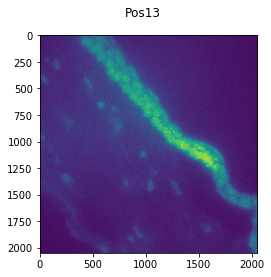

opening img_Pos14_000000025_000000000_DeepBlue_000_025.tif

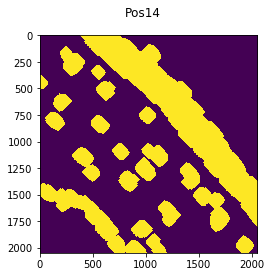

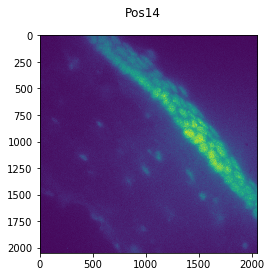

opening img_Pos15_000000025_000000000_DeepBlue_000_025.tif

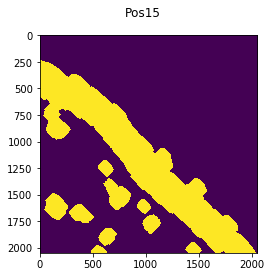

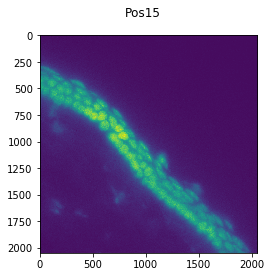

opening img_Pos16_000000025_000000000_DeepBlue_000_025.tif

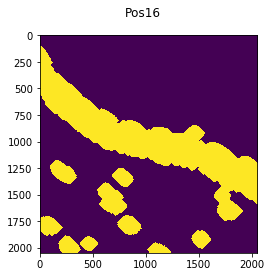

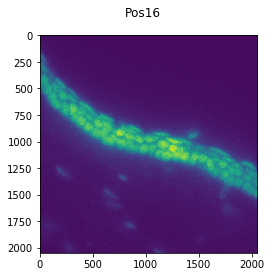

opening img_Pos17_000000025_000000000_DeepBlue_000_025.tif

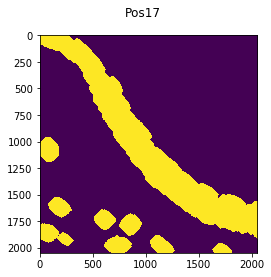

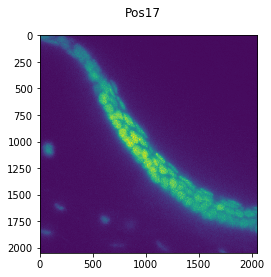

opening img_Pos18_000000025_000000000_DeepBlue_000_025.tif

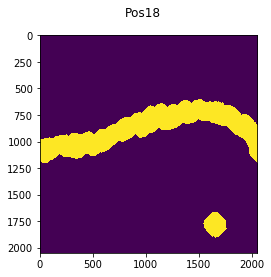

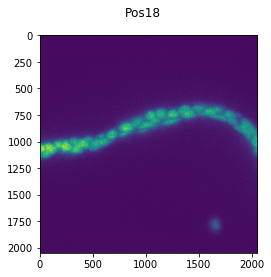

opening img_Pos19_000000025_000000000_DeepBlue_000_025.tif

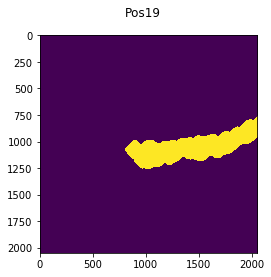

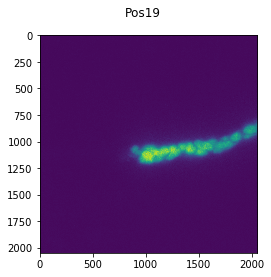

opening img_Pos28_000000025_000000000_DeepBlue_000_025.tif

KeyboardInterrupt: 

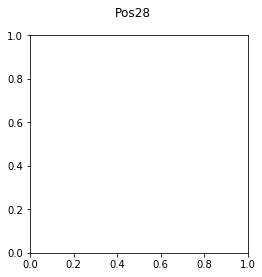

In [113]:
% matplotlib inline
import scipy.ndimage
from skimage.filters import threshold_local
z = 25
for pos in md.posnames:
    if 'Pos' in pos:
        img = md.stkread(Position=pos,Zindex=z,Channel='DeepBlue',acq='nucstain_1')
        thresh = threshold_local(img[:,:,0],325,offset=0)
        binary = img[:,:,0]>thresh
        erode = ndimage.binary_erosion(binary)
        remove = remove_small_objects(erode, min_size=500)
        fill = ndimage.binary_fill_holes(remove)
        dialate = ndimage.binary_dilation(fill,iterations=50)
        mask = ndimage.binary_fill_holes(dialate)
        plt.suptitle(pos)
        plt.imshow(mask)
        plt.show()
        plt.suptitle(pos)
        plt.imshow(img[:,:,0])
        plt.show()

In [114]:
md.acqnames

array(['acq_1', 'acq_2', 'hybe1_3', 'hybe2_4', 'hybe3_5', 'hybe4_6',
       'hybe5_7', 'hybe6_8', 'hybe7_9', 'hybe8_10', 'hybe9_11',
       'nucstain_12', 'nucstain_1'], dtype=object)

In [111]:
pos ='Pos1'
'Pos' in pos

True

In [466]:
#gene_stack = np.zeros((class_img.shape))
class_img = class_img
for i in range(168):
    unique = np.unique(class_img)
    if i==-1:
        pass
    elif i==0:
        if i in unique:
            gene_stack = class_img==i
        else:
            gene_stack = np.zeros((class_img.shape))
            print('gene',i,'has no spots')
    else:
        if i in unique:
            temp = class_img==i
        else:
            temp = np.zeros((class_img.shape))
            print('gene',i,'has no spots')
        gene_stack = np.dstack((gene_stack,temp))
        

gene 1 has no spots
gene 2 has no spots
gene 3 has no spots
gene 5 has no spots
gene 8 has no spots
gene 9 has no spots
gene 11 has no spots
gene 12 has no spots
gene 13 has no spots
gene 14 has no spots
gene 15 has no spots
gene 16 has no spots
gene 18 has no spots
gene 19 has no spots
gene 20 has no spots
gene 21 has no spots
gene 23 has no spots
gene 24 has no spots
gene 26 has no spots
gene 27 has no spots
gene 28 has no spots
gene 29 has no spots
gene 30 has no spots
gene 32 has no spots
gene 33 has no spots
gene 34 has no spots
gene 35 has no spots
gene 36 has no spots
gene 37 has no spots
gene 38 has no spots
gene 39 has no spots
gene 41 has no spots
gene 42 has no spots
gene 43 has no spots
gene 46 has no spots
gene 48 has no spots
gene 49 has no spots
gene 50 has no spots
gene 51 has no spots
gene 52 has no spots
gene 53 has no spots
gene 54 has no spots
gene 55 has no spots
gene 56 has no spots
gene 57 has no spots
gene 58 has no spots
gene 60 has no spots
gene 61 has no spot